In [15]:
import matplotlib.pyplot as plt
import hdf_reader
import PhysicsTool as pt


In [16]:
with hdf_reader.SRT_HDF_Reader('Measurements/ElevationScan180_20251001.hdf') as srt_reader:
    pos = srt_reader.get_object_positions()
    spec = srt_reader.get_power_spectrum()
    meta = srt_reader.get_spectrometer_metadata()
    time = srt_reader.get_time()

first_pass_mask = range(170//2)

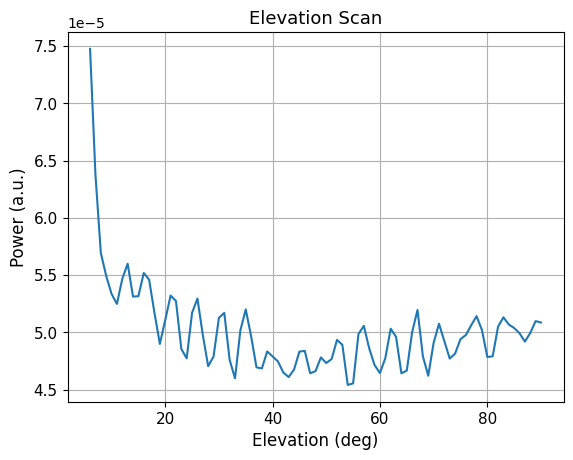

In [19]:
pt.plotting.start_plot('Elevation Scan', 'Elevation (deg)', 'Power (a.u.)')
plt.plot(pos['Elevation'][first_pass_mask], spec.sum(axis=1)[first_pass_mask])
pt.plotting.end_plot()